# CTP1 correlation analysis
Purpose: determine correlative effects between CTP1 and other genes

## Table of Contents

<h4>Import dependencies & custom functions</h4>
<h4>Part 0: Read in gene lists for analysis</h4>

### Import dependencies & custom functions

In [1]:
import os
import sys
import ast

import json
import scipy
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xpressplot as xp
import networkx as nx
from networkx.readwrite import json_graph

sns.set(font='arial')
sns.set(font_scale=float(.1))
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

from py_funcs import \
    read_table, \
    parse_genelist, \
    g_decompress, \
    make_gene_dict, \
    get_quantiles, \
    read_corr_data, \
    get_graph, \
    output_graph, \
    read_graph, \
    make_subgraph, \
    make_hist_gene, \
    make_clustermap

from combat import combat

__path__ = os.getcwd()

%matplotlib inline

In [2]:
_seed = 4000
random.seed(_seed)

### Part 0: Read in custom gene lists for analysis

In [3]:
query_name = 'CTP1'
query_id = 'YBR291C'

query_name2 = 'MCT1'
query_id2 = 'YOR221C'

custom_list = {
    query_name: query_id,
    query_name2: query_id2,
    "Mae1": "YKL029C",
    "Pyc1": "YGL062W",
    "Pyc2": "YBR218C",
    "Cit2": "YCR005C",
    "Cit3": "YPR001W",
    "GDH1": "GDH1",
    "Gdh2": "YDL215C",
    "DLD1": "DLD1",
    "DLD3": "DLD3",
}

In [4]:
print('Making gene dict')
gene_dict = make_gene_dict(__path__)

Making gene dict


### Part 1: Correlation analysis for mct1 RNA-seq data
**1. Download and make `Saccharomyces_cerevisiae.R64-1-1.103.gtf.gz` accessible in the appropriate directory**

In [5]:
yeast_gtf = read_table(
    url=os.path.join(
        __path__,
        "..",
        "data",
        "analysis_lists",
        "Saccharomyces_cerevisiae.R64-1-1.103.gtf.gz"),
    index_col=None,
    header=None,
    comment='#'
)

g_decompress(
    path=os.path.join(
        __path__,
        "..",
        "data",
        "analysis_lists"),
    file="Saccharomyces_cerevisiae.R64-1-1.103.gtf.gz",
    output="Saccharomyces_cerevisiae.R64-1-1.103.gtf"
)

**2. Import WT data**

In [6]:
# mct1-del vs WT
mct1_rnaseq = read_table(
    url=os.path.join(
        __path__,
        "..",
        "data",
        "mct1_rnaseq_data",
        "sce_mct1_deduped_count_table.tsv")
)
mct1_metadata = read_table(
    url=os.path.join(
        __path__,
        "..",
        "data",
        "mct1_rnaseq_data",
        "sce_mct1_metadata.txt"),
    index_col=False
)

# mct1-del vs sit4-del vs WT
mct1_sit4_rnaseq = read_table(
    url=os.path.join(
        __path__,
        "..",
        "data",
        "mct1_rnaseq_data",
        "mct1_sit4_counts_compiled.txt")
)
mct1_sit4_metadata = read_table(
    url=os.path.join(
        __path__,
        "..",
        "data",
        "mct1_rnaseq_data",
        "yeyun_18607R_metadata.txt")
)

print(mct1_rnaseq.shape)
print(mct1_sit4_rnaseq.shape)

(7127, 24)
(7126, 30)


**3. Join counts tables and metadata**

In [7]:
merged_df = pd.concat([mct1_rnaseq, mct1_sit4_rnaseq],axis=1)
merged_df = merged_df.dropna()
print(merged_df.shape)

(7126, 54)


In [8]:
mct1_metadata['Sample'] = mct1_metadata['Unnamed: 0']
mct1_metadata['Batch'] = "1"

mct1_sit4_metadata['Sample'] = mct1_sit4_metadata['ID']
mct1_sit4_metadata['Batch'] = "2"

merged_metadata = pd.concat([mct1_metadata[['Sample', 'Batch']], mct1_sit4_metadata[['Sample', 'Batch']]], axis=0)
merged_metadata.index = merged_metadata["Sample"]

**4. Get sample IDs for non-mct1-del**

In [9]:
mct1_names = mct1_metadata[['Unnamed: 0', 'Genotype']].loc[
    ~mct1_metadata[['Unnamed: 0', 'Genotype']]['Genotype'].str.contains('mct1')]['Unnamed: 0'].tolist()
mct1_sit4_names = mct1_sit4_metadata[['ID', 'Sample Name']].loc[
~mct1_sit4_metadata[['ID', 'Sample Name']]['Sample Name'].str.contains('mct1')]['ID'].tolist()

sample_ids = mct1_names + mct1_sit4_names

merged_df = merged_df[sample_ids]
print(merged_df.shape)

merged_metadata = merged_metadata.loc[sample_ids]
print(merged_metadata.shape)

(7126, 27)
(27, 2)


**5. Drop genes where min is less than 25**

In [10]:
merged_df_cutoff = merged_df.loc[merged_df.min(axis=1) > 25]

print(merged_df_cutoff.shape[0], 'genes,', merged_df_cutoff.shape[1], 'samples')

5427 genes, 27 samples


**6. Normalize**

In [11]:
rnaseq_norm = xp.tpm(
    data=merged_df_cutoff,
    gtf=os.path.join(
        __path__,
        "..",
        "data",
        "analysis_lists",
        "Saccharomyces_cerevisiae.R64-1-1.103.gtf"),
    identifier='gene_id'
)

**7. Convert gene IDs to names**

In [12]:
rnaseq_norm = xp.convert_names(
    rnaseq_norm, 
    os.path.join(
        __path__,
        "..",
        "data",
        "analysis_lists",
        "Saccharomyces_cerevisiae.R64-1-1.103.gtf.gz"),
    orig_name_label='gene_id',
    orig_name_location=0,
    new_name_label='gene_name',
    new_name_location=1,
    refill='source "sgd'
)

**8. Correct batch effects between datasets**
- dat is the expression/methylation data.
- batch is a list containing the batch variable

In [13]:
ebat = combat(
    rnaseq_norm, 
    merged_metadata["Batch"])

Adjusting data


found 2 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


**9. Export data**

In [14]:
# prevent negative numbers for downstream SpQN normalization
(ebat + 50).to_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        "mct1_mct1sit4_rnaseq_tpm25.tsv"),
    sep="\t"
)

### Part 2: CTP1 correlation analysis for lab WT data

**1. Demonstrate p-value inflation in transcriptomics datasets**

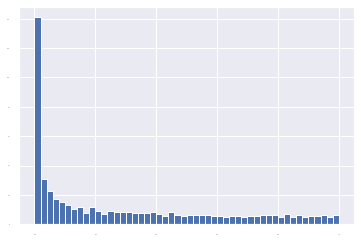

In [15]:
mct1_rnaseq_norm_c = ebat.copy()

for i in mct1_rnaseq_norm_c.index.tolist():
    r, p = scipy.stats.pearsonr(
        x=ebat.loc[query_name].values,
        y=ebat.loc[i].values)
    
    mct1_rnaseq_norm_c.at[i, "pearson_r_ctp1"] = r
    mct1_rnaseq_norm_c.at[i, "pearson_p_ctp1"] = p
    
ax = mct1_rnaseq_norm_c['pearson_p_ctp1'].hist(bins=50)

**2. CTP1 and anaplerotic gene correlations**

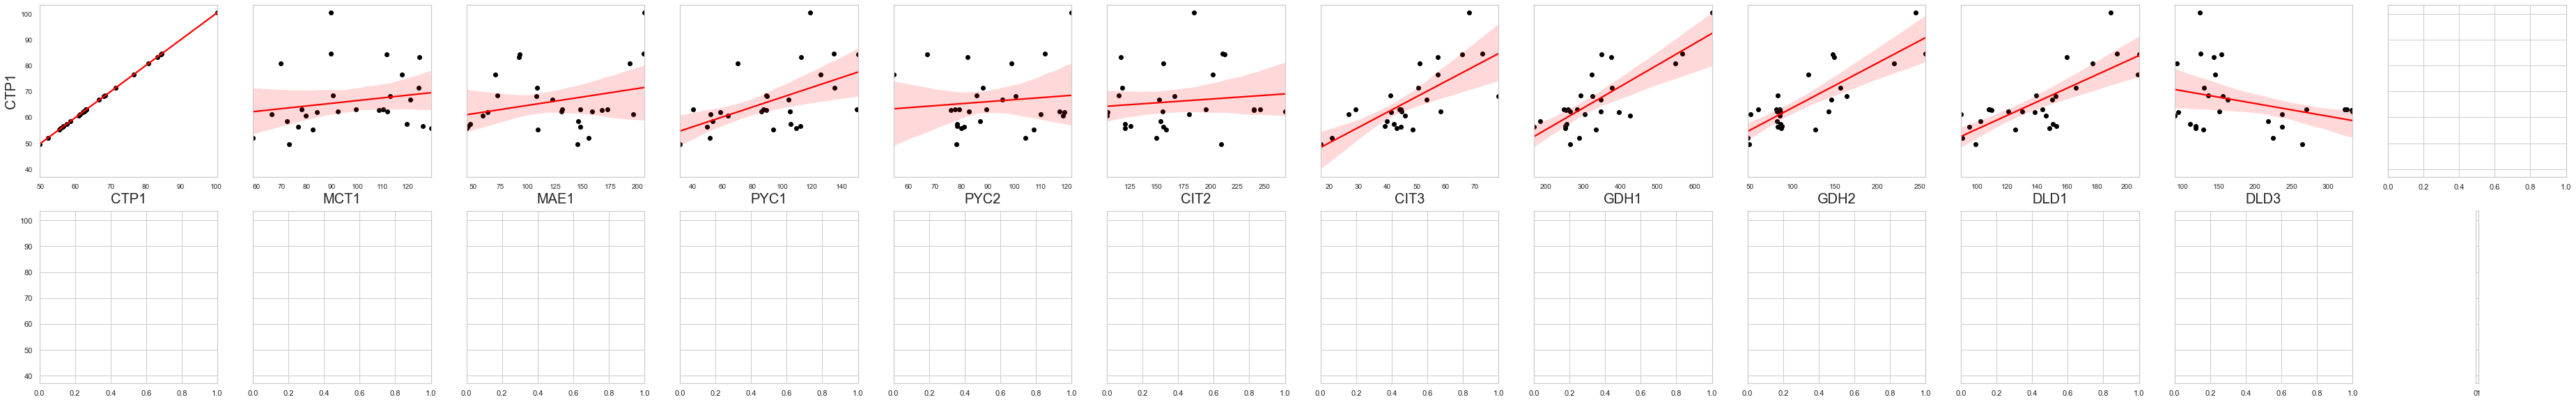

In [16]:
sns.set(font='arial')
sns.set_style("whitegrid")

f, axes = plt.subplots(2, len(custom_list.keys()) + 1, figsize=(65,10), sharey=True)
plt.gca().set_aspect('equal')

counter = 0
for k, v in custom_list.items():
    sns.regplot(
        x=ebat.T[k.upper()], 
        y=ebat.T[query_name], 
        seed=_seed, 
        ax=axes[0, counter],
        scatter_kws={'alpha': 1, 'color': 'black'},
        line_kws={"color": "red"}
    )
     
    if counter == 0:
        axes[0, counter].set_ylabel(query_name, fontsize = 20) # Y label
    else:
        axes[0, counter].set_ylabel("", fontsize = 20) # Y label
    axes[0, counter].set_xlabel(k.upper(), fontsize = 20) # X label
    
    axes[0, counter].tick_params(axis='both', which='major', labelsize=10)
    axes[0, counter].tick_params(axis='both', which='minor', labelsize=8)
    axes[0, counter].grid(False)
    
    counter += 1
    
f.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_anaplerotic_hits_lab-wt.svg"),
    bbox_inches="tight")

**3. Plot correlations of SpQN normalized lab yeast WT data**

In [17]:
file_name = "mct1_mct1sit4_rnaseq_tpm25_spqn_cor.tsv"

yeast_data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        file_name), 
    sep='\t'
)

In [18]:
ctp1_yeast_list = yeast_data.loc["CTP1"].loc[yeast_data.loc["CTP1"] > 0.75].sort_values(ascending=False)

In [19]:
for x in ctp1_yeast_list.index.tolist():
    print(x)

CTP1
SER1
SRY1
TCD2
ARG5,6
YCH1
KXD1
LYS20
ERG4
LYS12
ADE8
RAD59
FMP23
GNT1
DAL7
ACO2
GCR1
EAF5
LAP3
ENB1
PBP4
ANT1
LYS21
NTR2
HMF1


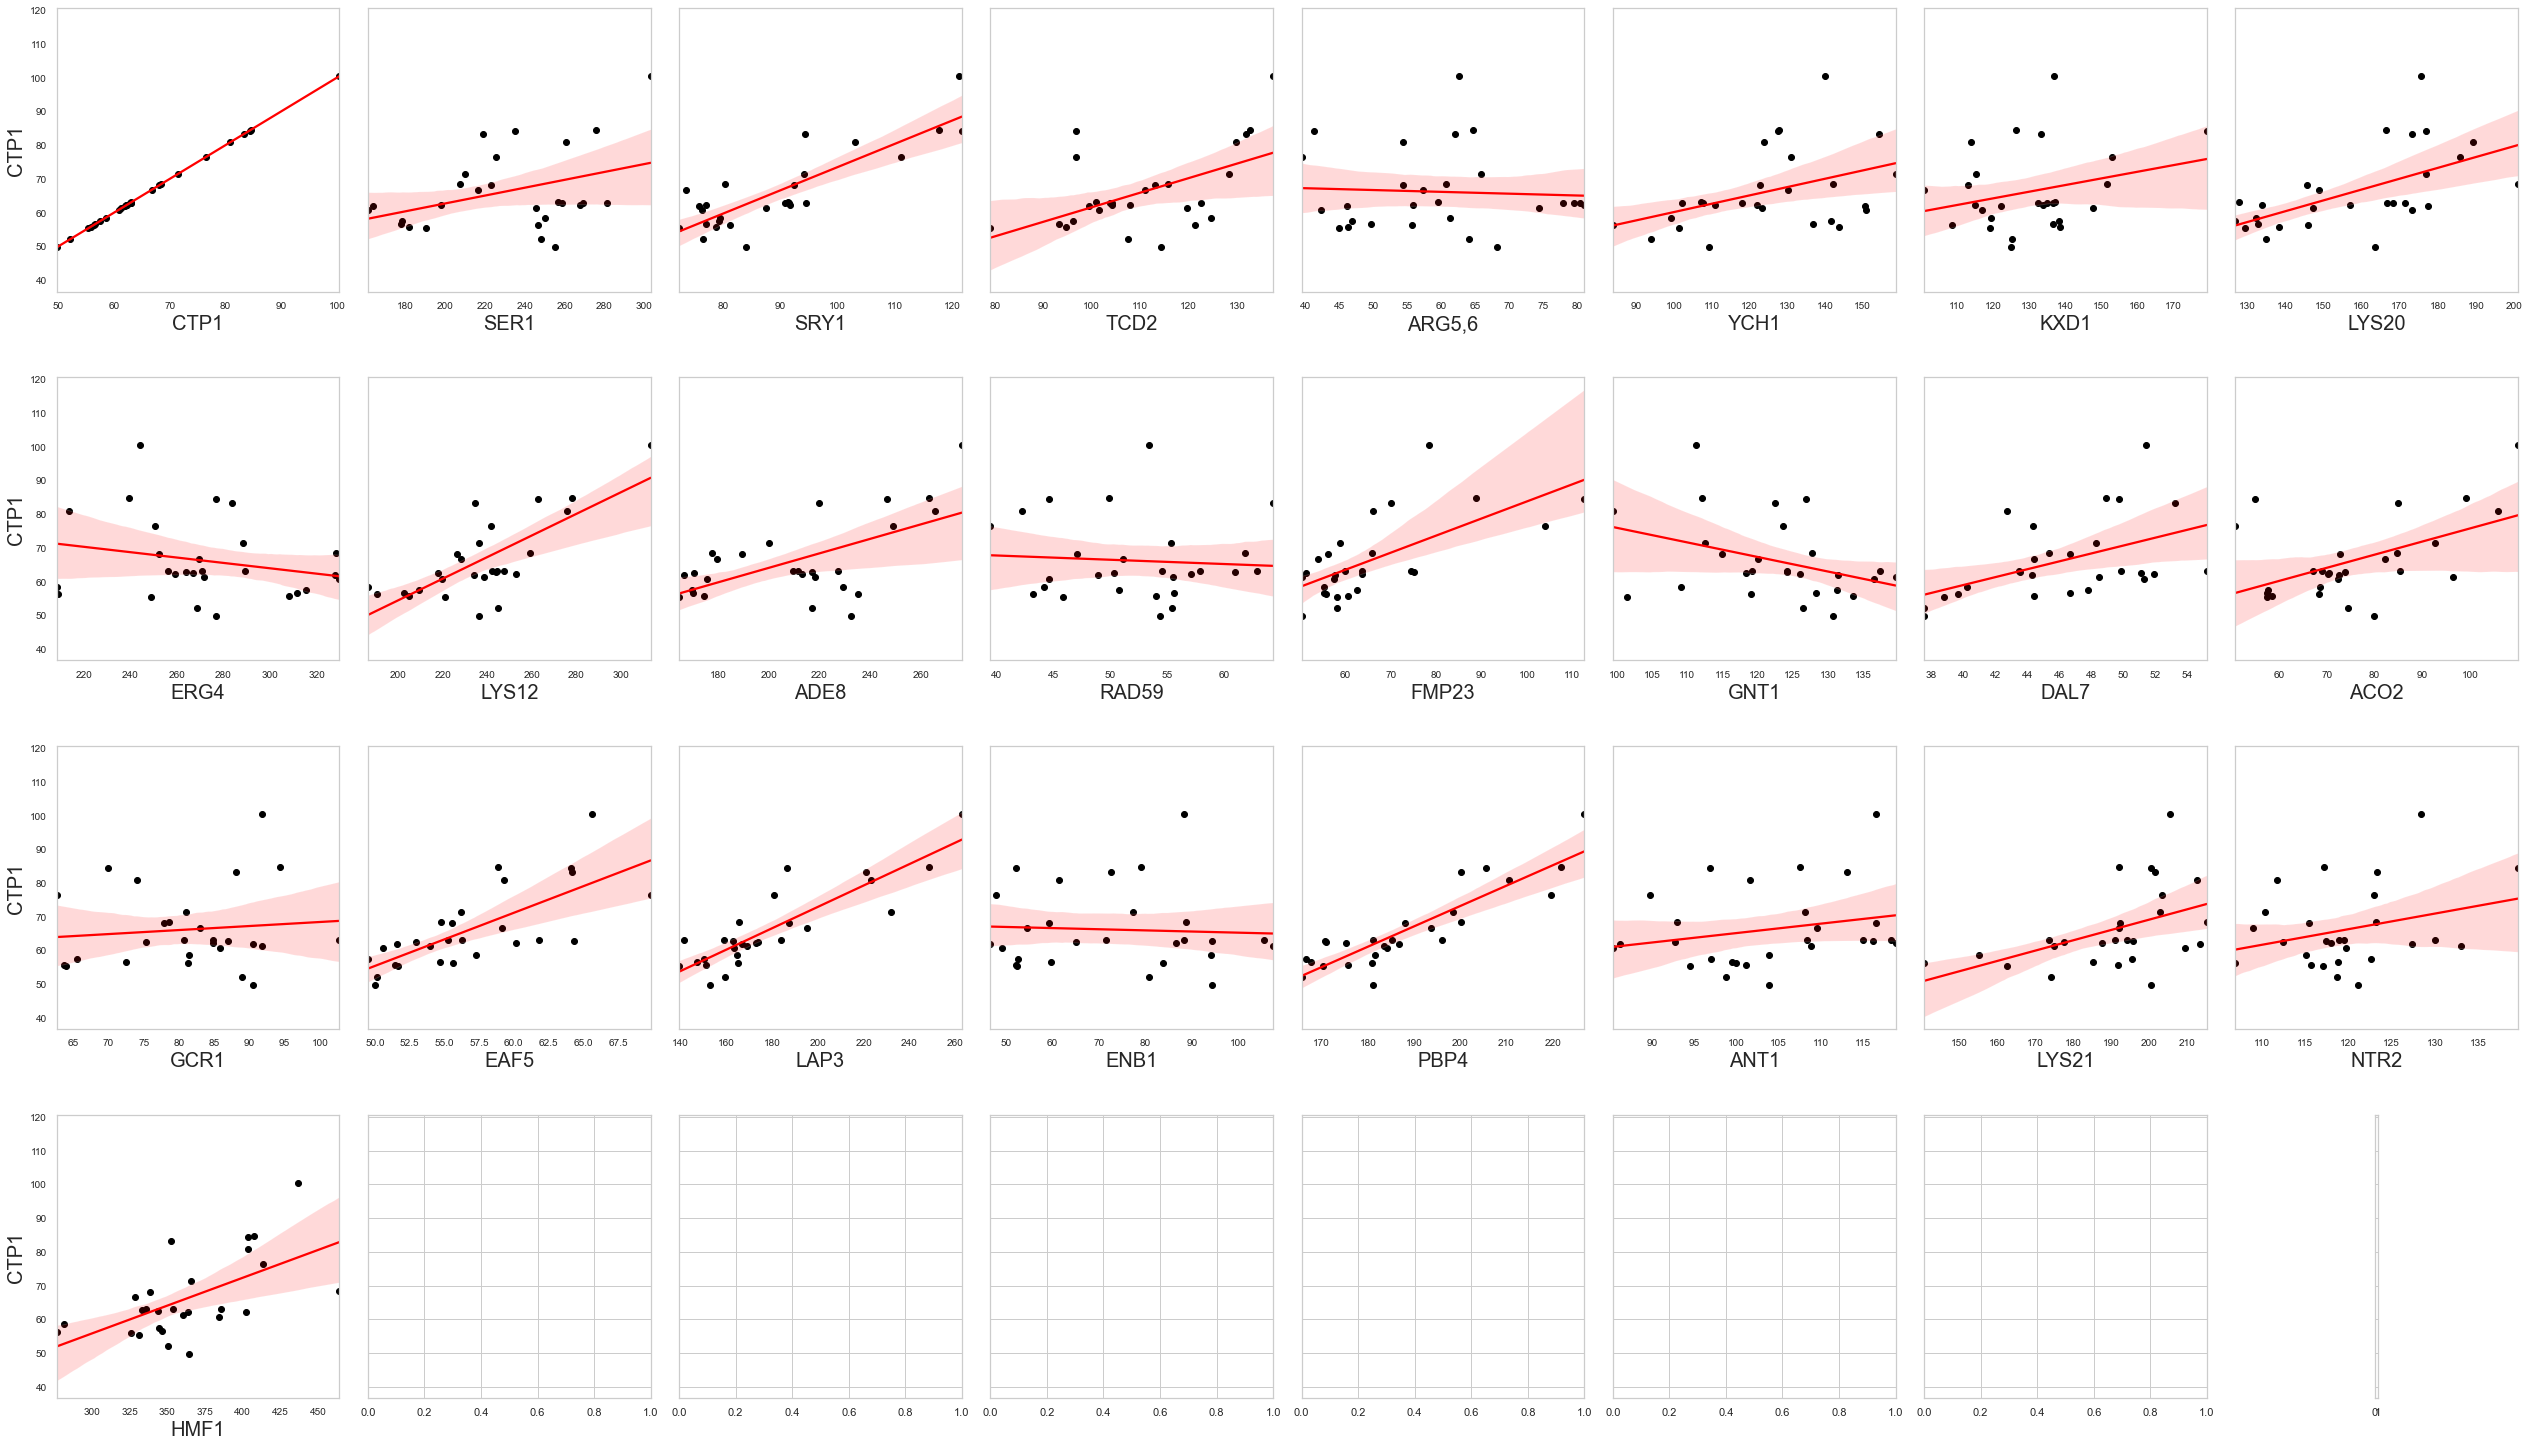

In [20]:
sns.set(font='arial')
sns.set_style("whitegrid")

f, axes = plt.subplots(4, 8, figsize=(35,20), sharey=True)
plt.gca().set_aspect('equal')
f.tight_layout()

plt.subplots_adjust(hspace = 0.3)

counter = 0
y_counter = 0
for k in ctp1_yeast_list.index.tolist():
    sns.regplot(
        x=ebat.T[k], 
        y=ebat.T["CTP1"], 
        seed=_seed, ax=axes[y_counter, counter], 
        scatter_kws={'alpha': 1, 'color': 'black'},
        line_kws={"color": "red"})
     
    if counter == 0:
        axes[y_counter, counter].set_ylabel("CTP1", fontsize = 20) # Y label
    else:
        axes[y_counter, counter].set_ylabel("", fontsize = 20) # Y label
    axes[y_counter, counter].set_xlabel(k, fontsize = 20) # X label
    
    axes[y_counter, counter].tick_params(axis='both', which='major', labelsize=10)
    axes[y_counter, counter].tick_params(axis='both', which='minor', labelsize=8)
    axes[y_counter, counter].grid(False)
    
    counter += 1
    
    if counter == 8:
        counter = 0 
        y_counter += 1
        
f.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_coexpression_hits_lab-wt.svg"),
    bbox_inches="tight")

## refine.bio yeast data analysis

In [21]:
refine_path = os.path.join(
    __path__,
    "..",
    "data",
    "refine.bio.yeast.all")
with open(
        os.path.join(refine_path, 'aggregated_metadata.json'), 'r') as jsonfile:
    metadata = json.load(jsonfile)

In [22]:
tables = []
for k in metadata['experiments'].keys():
    file = os.path.join(refine_path, k, k + ".tsv")
    data = pd.read_csv(
        file,
        sep='\t',
        index_col=0
    )
    data.index.name = None
    tables.append(data)
agg_data = pd.concat(tables, axis=1)

agg_data.to_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        "refine_bio_all.tsv"), 
    sep="\t")

print("Data dimensions:", agg_data.shape)

Data dimensions: (6752, 6370)


In [23]:
# WT strains cross-referenced with SGD, GEO, and EBI
include_terms = [
    'by4716',
    'by4741',
    'by4741 wild type',
    'by4742',
    'by4743',
    'cbs7960',
    'clib215',
    'clib324',
    'ec1118',
    'pw5',
    's288c',
    'sk1',
    'sls045 (diploid, s288c background)',
    't7',
    't73',
    'w303',
    'w303 wild-type',
    'w303a',
    'wide type',
    'wild-type',
    'wildtype',
    'wt',
    'wt by4742 (mata his3-delta-1 leu2-delta-0 lys2-delta-0 ura3-delta-0)',
    'ztw1, a wild type strain'
]

s = []

for k,v in metadata["samples"].items():
    if v["refinebio_cell_line"] in include_terms:
        s.append(k)
        
print(len(s), "wild-type samples found")

agg_data_wt = agg_data[s]
print("Data dimensions:", agg_data_wt.shape)

agg_data_wt.to_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        "refine_bio_wt.tsv"), 
    sep="\t")

1248 wild-type samples found
Data dimensions: (6752, 1248)


### Read corrected data 

#### WT data

In [24]:
file_name = "refine_bio_wt_spqn_cor.tsv"

data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        file_name), 
    sep='\t'
)

In [25]:
ctp1_list = data.loc["YBR291C"].loc[data.loc["YBR291C"] > 0.5].sort_values(ascending=False)
print(len(ctp1_list.index.tolist()), "genes\n")
for x in ctp1_list.index.tolist():
    print(gene_dict[x])

19 genes

CTP1
LYS4
ARG8
ACO2
MET17
PFA5
YIL165C
RTC2
LYS9
YCT1
MET2
SUL1
RFT1
YLL020C
PEX2
PUT4
YKE4
YIL100W
AGX1


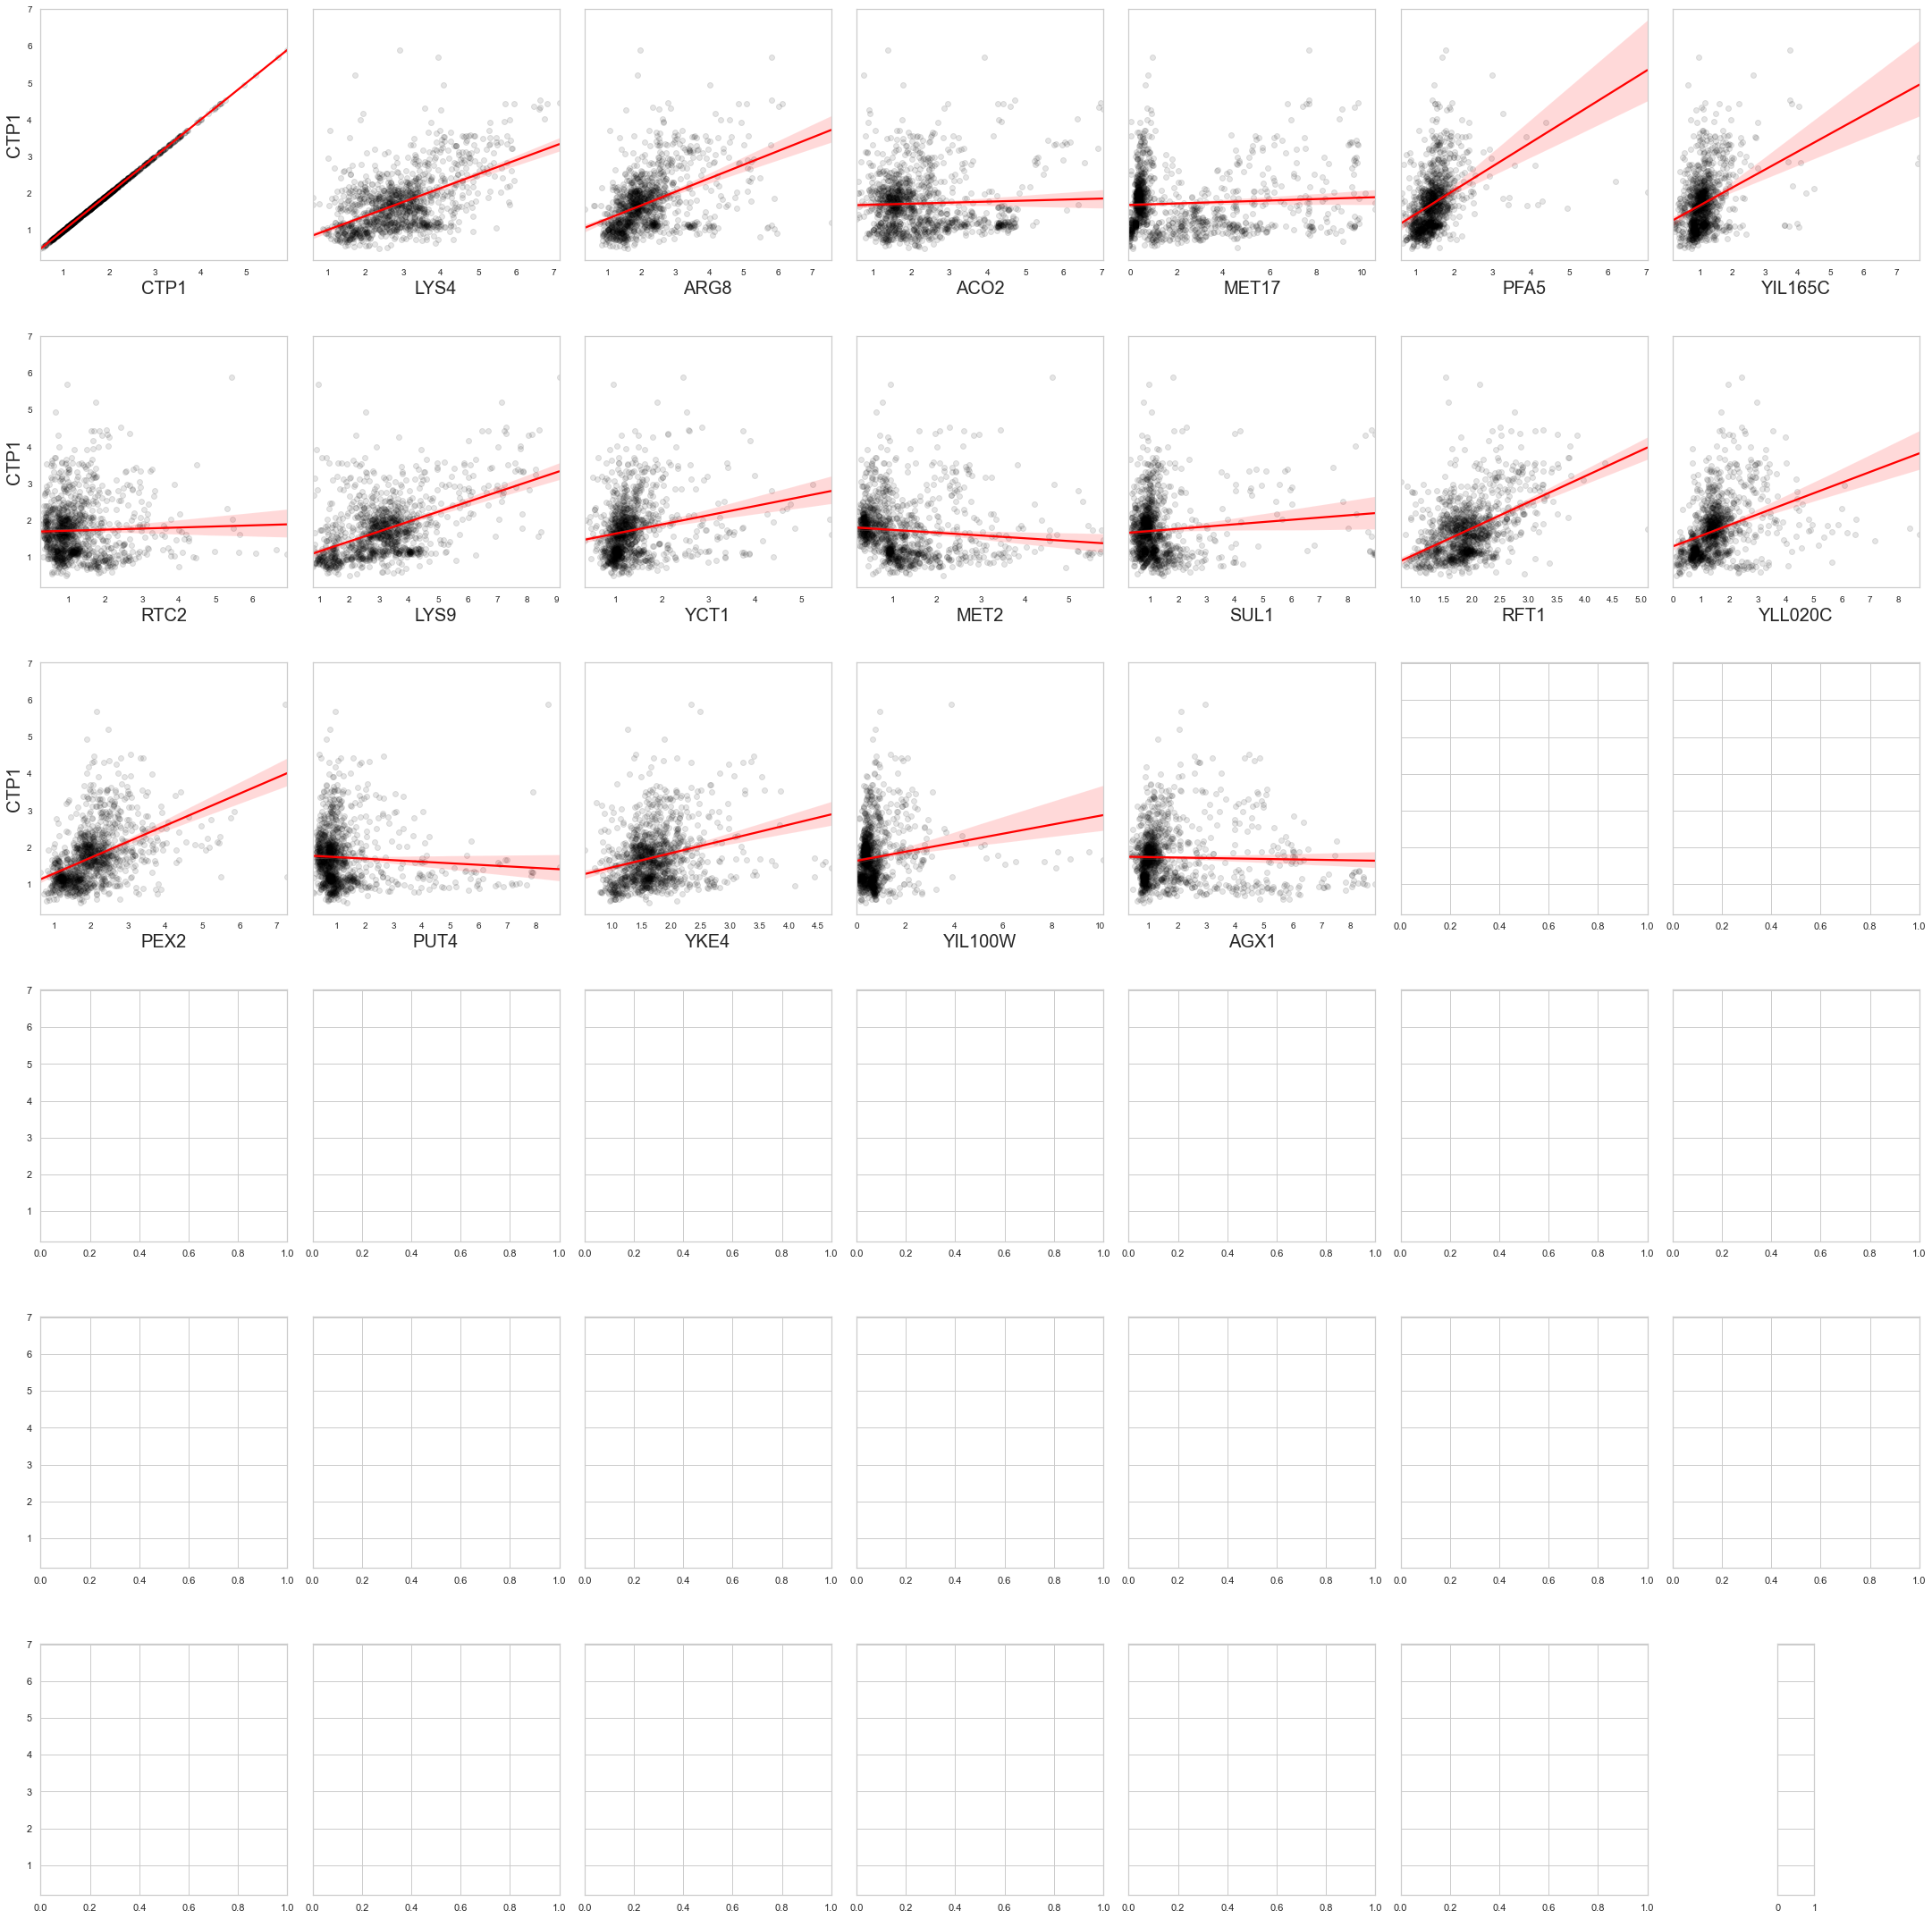

In [26]:
x_plots = 6
y_plots = 7
_figsize = (30,30)

sns.set(font='arial')
sns.set_style("whitegrid")

f, axes = plt.subplots(x_plots, y_plots, figsize=_figsize, sharey=True)
plt.gca().set_aspect('equal')
f.tight_layout()

plt.subplots_adjust(hspace = 0.3)

counter = 0
y_counter = 0
for k in ctp1_list.index.tolist()[0:47]:
    sns.regplot(
        x=agg_data_wt.T[k], 
        y=agg_data_wt.T["YBR291C"], 
        seed=_seed, 
        ax=axes[y_counter, counter], 
        scatter_kws={'alpha': 0.1, 'color': 'black'},
        line_kws={"color": "red"}
    )
    
    
    #agg_data_wt.T.plot.hexbin(
    #    x=k, 
    #    y="YBR291C", 
    #    gridsize=30, 
    #    ax=axes[y_counter, counter], 
    #    cmap="inferno")

    if counter == 0:
        axes[y_counter, counter].set_ylabel("CTP1", fontsize = 20) # Y label
    else:
        axes[y_counter, counter].set_ylabel("", fontsize = 20) # Y label
    axes[y_counter, counter].set_xlabel(gene_dict[k], fontsize = 20) # X label
    
    axes[y_counter, counter].tick_params(axis='both', which='major', labelsize=10)
    axes[y_counter, counter].tick_params(axis='both', which='minor', labelsize=8)
    axes[y_counter, counter].grid(False)
    
    counter += 1
    
    if counter == y_plots:
        counter = 0 
        y_counter += 1
        
f.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_coexpression_hits_wt.svg"),
    bbox_inches="tight")

#### All data

In [27]:
file_name = "refine_bio_all_spqn_cor.tsv"

data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        file_name), 
    sep='\t'
)

In [28]:
ctp1_list = data.loc["YBR291C"].loc[data.loc["YBR291C"] > 0.5].sort_values(ascending=False)
print(len(ctp1_list.index.tolist()), "genes\n")
for x in ctp1_list.index.tolist():
    print(gene_dict[x])

44 genes

CTP1
LYS9
LYS12
LYS4
ACO2
LYS1
CPA1
LYS21
YHM2
SUL1
MET5
LYS20
RTC2
ANS1
MET2
ARG3
PEX21
MET10
MET3
SUL2
LEU2
MET14
GRX8
ADE5,7
YLR302C
PEX11
ARG5,6
MEP2
MET13
STR3
MET1
MET16
HPT1
JJJ3
DAL3
YKR033C
LYS2
LYS14
CPA2
ARG8
MET17
PPH3
ODC2
SAM1


In [ ]:
x_plots = 6
y_plots = 8
_figsize = (35,30)

sns.set(font='arial')
sns.set_style("whitegrid")

f, axes = plt.subplots(x_plots, y_plots, figsize=_figsize, sharey=True)
plt.gca().set_aspect('equal')
f.tight_layout()

plt.subplots_adjust(hspace = 0.3)

counter = 0
y_counter = 0
for k in ctp1_list.index.tolist()[0:47]:
    sns.regplot(
        x=agg_data.T[k], 
        y=agg_data.T["YBR291C"], 
        seed=_seed, 
        ax=axes[y_counter, counter], 
        scatter_kws={'alpha': 0.1, 'color': 'black'},
        line_kws={"color": "red"})
     
    if counter == 0:
        axes[y_counter, counter].set_ylabel("CTP1", fontsize = 20) # Y label
    else:
        axes[y_counter, counter].set_ylabel("", fontsize = 20) # Y label
    axes[y_counter, counter].set_xlabel(gene_dict[k], fontsize = 20) # X label
    
    axes[y_counter, counter].tick_params(axis='both', which='major', labelsize=10)
    axes[y_counter, counter].tick_params(axis='both', which='minor', labelsize=8)
    axes[y_counter, counter].grid(False)
    
    counter += 1
    
    if counter == y_plots:
        counter = 0 
        y_counter += 1
        
f.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_coexpression_hits_all.svg"),
    bbox_inches="tight")

#### GO enrichment

In [ ]:
ctp1_go = "analysis-ctp1-lab-wt.txt"

ctp1_go_data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        ctp1_go),
    sep="\t",
    skiprows=11)


In [ ]:
# Manually remove redundant GO terms

In [ ]:
ctp1_go_data['GO biological process complete'].tolist()

In [ ]:
this_list = [
    'lysine biosynthetic process via aminoadipic acid (GO:0019878)',
    'purine nucleobase metabolic process (GO:0006144)',
    'aspartate family amino acid biosynthetic process (GO:0009067)',
    'alpha-amino acid biosynthetic process (GO:1901607)',
    'carboxylic acid biosynthetic process (GO:0046394)',
    'small molecule biosynthetic process (GO:0044283)',
    'oxoacid metabolic process (GO:0043436)'
]

In [ ]:
ctp1_go_data = ctp1_go_data.loc[ctp1_go_data['GO biological process complete'].isin(this_list)]
ctp1_go_data = ctp1_go_data[["GO biological process complete", "upload_1 (fold Enrichment)", "upload_1 (FDR)"]]

fold_sym = r'Fold Change'
abs_sym = r'| Fold Change |'

ctp1_go_data[fold_sym] = ctp1_go_data['upload_1 (fold Enrichment)'] #np.log2(ctp1_go_data['upload_1 (fold Enrichment)'])
ctp1_go_data[abs_sym] = abs(ctp1_go_data[fold_sym])
ctp1_go_data['-log10fdr'] = -1 * np.log10(ctp1_go_data['upload_1 (FDR)'])

ctp1_go_data = ctp1_go_data.sort_values(by="-log10fdr", ascending=False)
ctp1_go_data = ctp1_go_data.reindex(index=ctp1_go_data.index[::-1]).reset_index().drop("index", axis=1)
ctp1_go_data['index'] = ctp1_go_data.index + 1

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
plt.xlim((0,ctp1_go_data["-log10fdr"].max() + 2))

# use the scatterplot function to build the bubble map
sns.scatterplot(
    data=ctp1_go_data.round(decimals=2), 
    x="-log10fdr", 
    y="index", 
    size=abs_sym, 
    hue=fold_sym, 
    legend=True, 
    sizes=(1, 500),
    palette="dark:salmon_r",
    size_norm=(0, ctp1_go_data[abs_sym].max() + 1),
    hue_norm=(0, ctp1_go_data[abs_sym].max()))

ax.set_xlabel("-log$_1$$_0$(FDR)")
ax.set_ylabel("")
ax.get_yaxis().set_ticks([])
ax.set_title("CTP1 Correlation GO Terms", pad=15, fontsize=20)

for index, row in ctp1_go_data.iterrows():
    ax.text(s=row["GO biological process complete"], x=-0.5, y=row["index"], ha='right')

ax.legend(bbox_to_anchor=(1.05, 1.01), borderpad=1)

# show the graph
fig.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_go_enrichment_bubble-lab-wt.svg"),
    bbox_inches="tight")

In [ ]:
ctp1_go = "analysis-ctp1-wt.txt"

ctp1_go_data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        ctp1_go),
    sep="\t",
    skiprows=11)


In [ ]:
# Manually remove redundant GO terms

In [ ]:
ctp1_go_data['GO biological process complete'].tolist()

In [ ]:
this_list = [
    'lysine biosynthetic process via aminoadipic acid (GO:0019878)',
    'aspartate family amino acid biosynthetic process (GO:0009067)',
    'serine family amino acid metabolic process (GO:0009069)',
    'alpha-amino acid biosynthetic process (GO:1901607)',
    'carboxylic acid transmembrane transport (GO:1905039)',
    'carboxylic acid biosynthetic process (GO:0046394)',
    'small molecule biosynthetic process (GO:0044283)',
    'oxoacid metabolic process (GO:0043436)'
]

In [ ]:
ctp1_go_data = ctp1_go_data.loc[ctp1_go_data['GO biological process complete'].isin(this_list)]
ctp1_go_data = ctp1_go_data[["GO biological process complete", "upload_1 (fold Enrichment)", "upload_1 (FDR)"]]

fold_sym = r'Fold Change'
abs_sym = r'| Fold Change |'

ctp1_go_data[fold_sym] = ctp1_go_data['upload_1 (fold Enrichment)'] #np.log2(ctp1_go_data['upload_1 (fold Enrichment)'])
ctp1_go_data[abs_sym] = abs(ctp1_go_data[fold_sym])
ctp1_go_data['-log10fdr'] = -1 * np.log10(ctp1_go_data['upload_1 (FDR)'])

ctp1_go_data = ctp1_go_data.sort_values(by="-log10fdr", ascending=False)
ctp1_go_data = ctp1_go_data.reindex(index=ctp1_go_data.index[::-1]).reset_index().drop("index", axis=1)
ctp1_go_data['index'] = ctp1_go_data.index + 1

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5)
plt.xlim((0,ctp1_go_data["-log10fdr"].max() + 2))

# use the scatterplot function to build the bubble map
sns.scatterplot(
    data=ctp1_go_data.round(decimals=2), 
    x="-log10fdr", 
    y="index", 
    size=abs_sym, 
    hue=fold_sym, 
    legend=True, 
    sizes=(1, 500),
    palette="dark:salmon_r",
    size_norm=(0, ctp1_go_data[abs_sym].max() + 1),
    hue_norm=(0, ctp1_go_data[abs_sym].max()))

ax.set_xlabel("-log$_1$$_0$(FDR)")
ax.set_ylabel("")
ax.get_yaxis().set_ticks([])
ax.set_title("CTP1 Correlation GO Terms", pad=15, fontsize=20)

for index, row in ctp1_go_data.iterrows():
    ax.text(s=row["GO biological process complete"], x=-0.5, y=row["index"], ha='right')

ax.legend(bbox_to_anchor=(1.05, 1.01), borderpad=1)

# show the graph
fig.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_go_enrichment_bubble-wt.svg"),
    bbox_inches="tight")

In [ ]:
ctp1_go = "analysis-ctp1-all.txt"

ctp1_go_data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        ctp1_go),
    sep="\t",
    skiprows=11)


In [ ]:
ctp1_go_data = ctp1_go_data.iloc[0:40]

In [ ]:
# Manually remove redundant GO terms

In [ ]:
ctp1_go_data['GO biological process complete'].tolist()

In [ ]:
this_list = [
    'mitochondrial citrate transmembrane transport (GO:0006843)',
    'tricarboxylic acid transport (GO:0006842)',
    'citrulline biosynthetic process (GO:0019240)',
    'purine nucleobase metabolic process (GO:0006144)',
    'citrulline metabolic process (GO:0000052)',
    'citrate transport (GO:0015746)',
    'homoserine metabolic process (GO:0009092)',
    'glutamine family amino acid metabolic process (GO:0009064)',
    'ornithine metabolic process (GO:0006591)',
    'serine family amino acid biosynthetic process (GO:0009070)',
    'cysteine metabolic process (GO:0006534)',
    'nucleobase metabolic process (GO:0009112)',
    'sulfate reduction (GO:0019419)',
    'arginine metabolic process (GO:0006525)',
    'methionine biosynthetic process (GO:0009086)',
    'hydrogen sulfide biosynthetic process (GO:0070814)',
    'sulfur amino acid biosynthetic process (GO:0000097)',
    'sulfate assimilation (GO:0000103)',
    'lysine biosynthetic process via aminoadipic acid (GO:0019878)',
    'cellular amino acid metabolic process (GO:0006520)',
    'aspartate family amino acid biosynthetic process (GO:0009067)',
    'carboxylic acid biosynthetic process (GO:0046394)'
]

In [ ]:
ctp1_go_data = ctp1_go_data.loc[ctp1_go_data['GO biological process complete'].isin(this_list)]

ctp1_go_data = ctp1_go_data[["GO biological process complete", "upload_1 (fold Enrichment)", "upload_1 (FDR)"]]

fold_sym = r'Fold Change'
abs_sym = r'| Fold Change |'

ctp1_go_data[fold_sym] = ctp1_go_data['upload_1 (fold Enrichment)'] #np.log2(ctp1_go_data['upload_1 (fold Enrichment)'])
ctp1_go_data[abs_sym] = abs(ctp1_go_data[fold_sym])
ctp1_go_data['-log10fdr'] = -1 * np.log10(ctp1_go_data['upload_1 (FDR)'])

ctp1_go_data = ctp1_go_data.sort_values(by="-log10fdr", ascending=False)
ctp1_go_data = ctp1_go_data.reindex(index=ctp1_go_data.index[::-1]).reset_index().drop("index", axis=1)
ctp1_go_data['index'] = ctp1_go_data.index + 1

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 10)
plt.xlim((0,ctp1_go_data["-log10fdr"].max() + 2))

# use the scatterplot function to build the bubble map
sns.scatterplot(
    data=ctp1_go_data.round(decimals=2), 
    x="-log10fdr", 
    y="index", 
    size=abs_sym, 
    hue=fold_sym, 
    legend=True, 
    sizes=(1, 500),
    palette="dark:salmon_r",
    size_norm=(0, ctp1_go_data[abs_sym].max() + 1),
    hue_norm=(0, ctp1_go_data[abs_sym].max()))

ax.set_xlabel("-log$_1$$_0$(FDR)")
ax.set_ylabel("")
ax.get_yaxis().set_ticks([])
ax.set_title("CTP1 Correlation GO Terms", pad=15, fontsize=20)

for index, row in ctp1_go_data.iterrows():
    ax.text(s=row["GO biological process complete"], x=-0.5, y=row["index"], ha='right')

ax.legend(bbox_to_anchor=(1.05, 1.01), borderpad=1)

# show the graph
fig.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_go_enrichment_bubble-all.svg"),
    bbox_inches="tight")

### Clean-up

In [ ]:
# close GTF
os.remove(os.path.join(
    __path__,
    "..",
    "data",
    "analysis_lists",
    "Saccharomyces_cerevisiae.R64-1-1.103.gtf")
)